# Dehergne repertoire analysis

> First time use: follow instructions in the [README.md](README.md) file in this directory.

## Check version of timelink

If the cell bellow updates timelink a Restart of the notebook is needed (click Restart in the bar on top of this window)

In [1]:
%%capture
%pip install --upgrade timelink

## Extensions for this notebook 
(to later migrate to timelink-py)

In [59]:

from datetime import datetime
import pandas as pd
from timelink.kleio.utilities import format_timelink_date

def convert_timelink_date(tl_date: str, format='%Y%m%d') -> datetime:
    """Convert a Timelink date in the format YYYYMMDD to a Python datetime

    Args:
    tl_date: a string representing a date in the format YYYYMMDD
    format: the format used to scan the date string
    Dates can be incomplete: 1586 or 1586-03 or 158603

    Zeros can be used to register unknown values: 15860000 or 15860300

    Missing information is handled in the following way:
    * If the year is missing returns None
    * If the month is missing, returns the 2nd of July of that year (middle day of the year)
    * If the day is missing, returns the 15th of the month (middle day of the month)
            """
    # return None if tl_date is None
    if tl_date is None:
        return None
    # if tl_date is not a string, return None
    if not isinstance(tl_date, str):
        return None
    # remove dashes
    tl_date_clean = tl_date.replace('-','')
    # pad tl_date with zeros up to length 8
    tl_date_clean = tl_date_clean.ljust(8,'0')
    year, month, day = tl_date_clean[:4], tl_date_clean[4:6], tl_date_clean[6:]
    # handle the case where month is zero by setting the month to 07 and day to 02 (middle day of year)
    if year == '0000':
        return None
    elif month == '00':
        month = '07'
        day = '02'
    elif day == '00':
        day = '15'

    new_date = year + month + day
    try:
        result = datetime.strptime(new_date, format)
    except ValueError as BadDate:
        print(tl_date, tl_date_clean)
        print(BadDate)
        result=None
    return result

def calc_age_at(date_birth, today):
    """Compute the number of years between two dates"""
    # return None if either argument is None
    if date_birth is None or today is None:
        return None
    # Ensure the dates are datetime objects
    if not isinstance(date_birth, datetime):
        date_birth = convert_timelink_date(date_birth)
    if not isinstance(today, datetime):
        today = convert_timelink_date(today)

    if date_birth is None or today is None:
        return None

    # Compute the difference in years
    difference_in_years = (today - date_birth).days / 365.25
    return int(difference_in_years)


print("testing")
print(format_timelink_date('00000000'))
print(format_timelink_date(None))
print(format_timelink_date('1582'))
print(format_timelink_date('158203'))
print(format_timelink_date('1582-03-02'))
print(format_timelink_date('15820302'))
print(calc_age_at('1980-01-01', '2020-01-01'))
print(calc_age_at('1980-01-01', 0))

testing


1582
1582-03
1582-03-02
1582-03-02
40
None


## Initial setup

Create a TimelinkNotebook object. This will be the interface for most of your interactions with Timelink.

The first time you run this notebook, you will be prompted to install ìpykernel. This is required to run Timelink in a notebook.

Note:
* First time run takes a little time as the required Docker images are downloaded.
* Timelink will default to using sqlite as the database, see [Receipts notebook for more control](1-receipts.ipynb)


In [12]:
from timelink.notebooks import TimelinkNotebook

tlnb = TimelinkNotebook()
tlnb.print_info(show_token=True)

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running stamp_revision  -> 36cdd078f890
DEBUG [alembic.runtime.migration] new branch insert 36cdd078f890
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Timelink version: 1.1.15
Project name: dehergne-locations
Project home: /Users/jrc/mhk-home/sources/dehergne-locations
Database type: sqlite
Database name: dehergne_locations
Kleio image: timelinkserver/kleio-server
Kleio server token: GFd0uitj2ZiVDjVvEEz8V09iIlq57yeW
Kleio server URL: http://127.0.0.1:8088
Kleio server home: /Users/jrc/mhk-home/sources/dehergne-locations
Kleio server container: objective_einstein
Kleio version requested: latest
Kleio server version: 12.6.577 (2024-10-24 16:53:53)
SQLite directory: /Users/jrc/mhk-home/sources/dehergne-locations/database/sqlite
Call print_info(show_password=True) to show the Postgres password
TimelinkNotebook(project_name=dehergne-locations, project_home=/Users/jrc/mhk-home/sources/dehergne-locations, db_type=sqlite, db_name=dehergne_locations, kleio_image=timelinkserver/kleio-server, kleio_version=latest, postgres_image=postgres, postgres_version=latest)


### Database status

Count the number of rows in each table in the database.


In [60]:
tlnb.table_row_count_df()

,table,count
0,acts,29
1,alembic_version,1
2,aregisters,1
3,attributes,26075
4,blinks,0
5,class_attributes,70
6,classes,14
7,entities,32270
8,geoentities,359
9,goods,0


## Check the status of the files

Check the import status of the translated files

* I: Imported
* E: Imported with error
* W: Imported with warnings no errors
* N: Not imported
* U: Translation updated need to reimport

In [14]:
kleio_files = tlnb.get_kleio_files()
# kleio_files.info()
kleio_files[["name","import_status","status","errors","warnings","imported","import_errors","import_warnings"]]

,name,import_status,status,errors,warnings,imported,import_errors,import_warnings
0,dehergne-0-abrev.cli,N,V,0,0,None,0,0
1,dehergne-a.cli,N,V,0,0,None,0,0
2,dehergne-b.cli,N,V,0,0,None,0,0
3,dehergne-c.cli,N,V,0,0,None,0,0
4,dehergne-d.cli,N,V,0,0,None,0,0
5,dehergne-e.cli,N,V,0,0,None,0,0
6,dehergne-f.cli,N,V,0,0,None,0,0
7,dehergne-g.cli,N,V,0,0,None,0,0
8,dehergne-h.cli,N,V,0,0,None,0,0
9,dehergne-i.cli,N,V,0,0,None,0,0


List files with import errors

In [15]:
eids = kleio_files[kleio_files["import_status"]=='E'].index
print(eids)
rpt = tlnb.get_import_rpt(kleio_files,rows=list(eids))
print(rpt)

Index([], dtype='int64')




## Update the database from Kleio sources.

Updates source translations and imports into database sources with no errors.

Only changed files since last import, or new files, will be processed.

When importing to an empty database some errors can be generated
if some files contain "xsame_as/xmesmo_que" links to other files
not yet imported.

This is solved by reimporting the files in error after the first import, so that the cross references are solved. Ensure that
that `update_from_sources` is called with ``with_import_errors=True``.

It may be necessary a third import run
to solve all cross references.

In [16]:
import logging
logging.basicConfig(level=logging.INFO)

tlnb.update_from_sources(with_import_errors=True)

/Users/jrc/develop/timelink-py/timelink/kleio/groups/kgroup.py:738: UserWarning: Created a KElement class for dbase. Better to create explicit or provide  synonyms= in group creation.
  el = self.pack_as_kelement(arg, value)
/Users/jrc/develop/timelink-py/timelink/kleio/groups/kgroup.py:738: UserWarning: Created a KElement class for user. Better to create explicit or provide  synonyms= in group creation.
  el = self.pack_as_kelement(arg, value)
/Users/jrc/develop/timelink-py/timelink/kleio/groups/kgroup.py:738: UserWarning: Created a KElement class for mode. Better to create explicit or provide  synonyms= in group creation.
  el = self.pack_as_kelement(arg, value)
/Users/jrc/develop/timelink-py/timelink/kleio/groups/kgroup.py:738: UserWarning: Created a KElement class for status. Better to create explicit or provide  synonyms= in group creation.
  el = self.pack_as_kelement(arg, value)
/Users/jrc/develop/timelink-py/timelink/kleio/groups/kgroup.py:738: UserWarning: Created a KElement c

## Nacionality / Nacionalidades

In [17]:
import pandas as pd
from timelink.pandas import attribute_values
# set max rows to 500
pd.set_option('display.max_rows', 500)

df_totals = attribute_values('nacionalidade',db=tlnb.db)
df_totals

,count,date_min,date_max
value,,,
Portugal,431,0,0
França,184,0,0
China,177,0,0
Itália,125,0,0
Espanha,43,0,0
Alemanha,36,0,0
Bélgica,23,0,0
Áustria,15,0,0
Flandres,12,0,0


### List of all with attribute "nacionalidade"

In [18]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

nacionais = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['nascimento'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
nacionais = nacionais[nacionais.groupname=='n']
nacionais.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, deh-antonio-de-abreu to deh-andre-doria
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id_1                 942 non-null    object
 1   name                 942 non-null    object
 2   groupname            942 non-null    object
 3   nacionalidade.type   942 non-null    object
 4   nacionalidade        942 non-null    object
 5   nacionalidade.date   942 non-null    object
 6   nacionalidade.line   942 non-null    int64 
 7   nacionalidade.level  942 non-null    int64 
 8   nacionalidade.obs    942 non-null    object
 9   nascimento           854 non-null    object
 10  nascimento.date      854 non-null    object
 11  nascimento.obs       854 non-null    object
dtypes: int64(2), object(10)
memory usage: 95.7+ KB


### Export all with attribute "nacionalidade"

In [89]:
nacionais.to_excel("../inferences/paises_pessoas_n.xlsx", sheet_name='Sheet1', index=False)

### Group by nacionalidade

In [19]:
paises_totais=nacionais.groupby('nacionalidade')['id_1'].nunique().reset_index().sort_values('id_1',ascending=False)
paises_totais

,nacionalidade,id_1
19,Portugal,346
10,França,168
4,China,146
14,Itália,113
0,Alemanha,35
7,Espanha,34
3,Bélgica,22
24,Áustria,14
9,Flandres,11
2,Boémia,10


In [91]:
paises_totais.to_excel("../inferences/paises_totais_n.xlsx", sheet_name='Sheet1', index=False)

### Countries and evolution of departures

In [20]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

embarques = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['wicky'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
embarques = embarques[embarques.groupname=='n']
embarques['wicky.date'] = embarques['wicky.date'].fillna('0000')
embarques.info()
cols =['name','nacionalidade','wicky.date']
# replace NaN in wicky.date with 0000

embarques[cols].sort_values('wicky.date').head()

<class 'pandas.core.frame.DataFrame'>
Index: 973 entries, aloys-moriz to joao-cardoso
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id_1                 973 non-null    object
 1   name                 973 non-null    object
 2   groupname            973 non-null    object
 3   nacionalidade.type   973 non-null    object
 4   nacionalidade        973 non-null    object
 5   nacionalidade.date   973 non-null    object
 6   nacionalidade.line   973 non-null    int64 
 7   nacionalidade.level  973 non-null    int64 
 8   nacionalidade.obs    973 non-null    object
 9   wicky                515 non-null    object
 10  wicky.date           973 non-null    object
 11  wicky.obs            515 non-null    object
dtypes: int64(2), object(10)
memory usage: 98.8+ KB


,name,nacionalidade,wicky.date
id,,,
deh-joao-mendes,João Mendes,Portugal,0
deh-manuel-da-fonseca,Manuel da Fonseca,Portugal,0
deh-joaquim-lobo,Joaquim Lobo,Portugal,0
deh-joao-da-cunha,João da Cunha,Portugal,0
deh-francisco-pinto-ii,Francisco Pinto,Portugal,0


#### Group by country decade

In [21]:
# extract the year from wicky.date
embarques['ano_embarque'] = embarques['wicky.date'].str[:4]
# convert 'ano_entrada' to integer
embarques['ano_embarque'] = embarques['ano_embarque'].astype(int)
# count ano_entrada per periods of 10 years starting from 1540
embarques['periodo_embarque'] = embarques['ano_embarque'] // 10 * 10
# show columns jesuita-entrada.date, ano_entrada, periodo
embarques[['wicky.date','ano_embarque','periodo_embarque']].sort_values('wicky.date').tail(10)
# count number of embarques per period
embarques.groupby(['nacionalidade','periodo_embarque',])['id_1'].count().reset_index().sort_values(['nacionalidade','periodo_embarque',])


,nacionalidade,periodo_embarque,id_1
0,Alemanha,0,7
1,Alemanha,1610,3
2,Alemanha,1630,1
3,Alemanha,1650,3
4,Alemanha,1680,2
5,Alemanha,1690,6
6,Alemanha,1700,3
7,Alemanha,1710,4
8,Alemanha,1730,5
9,Alemanha,1740,1


### Countries and place of entry / Países e locais de entrada

In [22]:

import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

nacionalidade_entrada = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['nascimento', 'jesuita-entrada','jesuita-entrada-x'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
nacionalidade_entrada = nacionalidade_entrada[nacionalidade_entrada.groupname=='n']
nacionalidade_entrada['jesuita-entrada'] = nacionalidade_entrada['jesuita-entrada'].fillna('?')
nacionalidade_entrada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949 entries, aloys-moriz to joao-cardoso
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_1                  949 non-null    object
 1   name                  949 non-null    object
 2   groupname             949 non-null    object
 3   nacionalidade.type    949 non-null    object
 4   nacionalidade         949 non-null    object
 5   nacionalidade.date    949 non-null    object
 6   nacionalidade.line    949 non-null    int64 
 7   nacionalidade.level   949 non-null    int64 
 8   nacionalidade.obs     949 non-null    object
 9   nascimento            861 non-null    object
 10  nascimento.date       861 non-null    object
 11  nascimento.obs        861 non-null    object
 12  jesuita-entrada       949 non-null    object
 13  jesuita-entrada.date  845 non-null    object
 14  jesuita-entrada.obs   845 non-null    object
 15  jesuita-entrada-x     0 no

In [23]:
nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique()
df = nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique().reset_index()
df_subtotal = df.groupby('nacionalidade')['id_1'].sum().reset_index()
df_subtotal.columns = ['nacionalidade', 'subtotal']
df = pd.merge(df, df_subtotal, on='nacionalidade')
df['perc_nacionalidade'] = df['id_1']/df['subtotal']
df.sort_values(['subtotal','nacionalidade','id_1'], ascending=[False,True,False])


,nacionalidade,jesuita-entrada,id_1,subtotal,perc_nacionalidade
99,Portugal,?,202,347,0.582133
100,Portugal,Coimbra,58,347,0.167147
103,Portugal,Lisboa,37,347,0.106628
107,Portugal,Évora,22,347,0.063401
101,Portugal,Goa,20,347,0.057637
104,Portugal,Macau,3,347,0.008646
102,Portugal,Japão,2,347,0.005764
105,Portugal,Ormuz,1,347,0.002882
106,Portugal,Portugal,1,347,0.002882
108,Portugal,Índia,1,347,0.002882


In [24]:
df = nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique().reset_index()
df_subtotal = df.groupby('nacionalidade')['id_1'].sum().reset_index()
df_subtotal.columns = ['nacionalidade', 'subtotal']
df = pd.merge(df, df_subtotal, on='nacionalidade')
df['perc_nacionalidade'] = df['id_1']/df['subtotal']
df

,nacionalidade,jesuita-entrada,id_1,subtotal,perc_nacionalidade
0,Alemanha,?,15,35,0.428571
1,Alemanha,Brno,2,35,0.057143
2,Alemanha,Landsberg,7,35,0.200000
3,Alemanha,Mainz,1,35,0.028571
4,Alemanha,Polotsk,1,35,0.028571
5,Alemanha,Portugal,1,35,0.028571
6,Alemanha,Roma,3,35,0.085714
7,Alemanha,Trier,3,35,0.085714
8,Alemanha,Viena,2,35,0.057143
9,Alsácia,Landsberg,1,2,0.500000


## Jesuit Entry (jesuita-entrada)

The attribute `jesuita-entrada` records the jesuit college/noviciate
where the future missionary enrolled in the Society of Jesus.

Note that a few entries have more than one value for `jesuita-entrada`
because the person dropped out after the first enrollement and later enrolled again.

### jesuita-entrada (totals)

In [25]:
import pandas as pd
from timelink.pandas import attribute_values
# set max rows to 500
pd.set_option('display.max_rows', 500)

df_totals = attribute_values('jesuita-entrada',db=tlnb.db)
df_totals.info()
df_totals['data_inicial'] = df_totals['date_min'].apply(format_timelink_date)
df_totals['data_final'] = df_totals['date_max'].apply(format_timelink_date)
# Extract the first 4 characters of data_inicial to get the year, store in column Ano_inicial
df_totals['Ano_inicial'] = df_totals['data_inicial'].str[:4]
# Extract the first 4 characters of data_final to get the year, store in column Ano_final
df_totals['Ano_final'] = df_totals['data_final'].str[:4]
df_totals

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, ? to Índia
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   count     67 non-null     int64 
 1   date_min  67 non-null     object
 2   date_max  67 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


,count,date_min,date_max,data_inicial,data_final,Ano_inicial,Ano_final
value,,,,,,,
?,484,15440000,17880828,1544,1788-08-28,1544,1788
Coimbra,60,15420000,17420427,1542,1742-04-27,1542,1742
Lisboa,45,15460000,17530612,1546,1753-06-12,1546,1753
Paris,41,16300108,17590310,1630-01-08,1759-03-10,1630,1759
Roma,40,15480311,17560709,1548-03-11,1756-07-09,1548,1756
Goa,33,15480000,17360000,1548,1736,1548,1736
Évora,26,15660714,17460405,1566-07-14,1746-04-05,1566,1746
Nancy,15,16270929,17510827,1627-09-29,1751-08-27,1627,1751
Landsberg,14,16230729,17571009,1623-07-29,1757-10-09,1623,1757


#### Export to Excel

In [98]:
df_totals.to_excel("../inferences/jesuita-entrada_totals.xlsx", sheet_name='Sheet_name_1')

### All know places of entry (todos os lugares de entrada conhecidos)

In [26]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    more_attributes=['nacionalidade','nascimento'],
    db=tlnb.db,
)
jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['nacionalidade'] = jesuita_entrada_full['nacionalidade'].fillna('')
jesuita_entrada_full['name'] = jesuita_entrada_full['name'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['nacionalidade_sort'] = jesuita_entrada_full['nacionalidade'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

# save those with jesuita-entrada not equal to '?'
# entrada_known = jesuita_entrada_full['jesuita-entrada'] != '?'
only_n = jesuita_entrada_full.fillna('').groupname == 'n'
jesuita_entrada_full = jesuita_entrada_full[only_n]
cols=['jesuita-entrada','jesuita-entrada.date','name','nacionalidade','nascimento','jesuita-entrada.obs']
# jesuita_entrada_full[(only_n) & (entrada_known)].sort_values(by=['jesuita-entrada','jesuita-entrada.date','name_sort','nascimento'])[cols].head(70)
jesuita_entrada_full.sort_values(by=['jesuita-entrada.date','jesuita-entrada','name_sort','nascimento'])[cols].head(70)



<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, aloys-moriz to joao-cardoso
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   963 non-null    object
 1   groupname              963 non-null    object
 2   jesuita-entrada.type   963 non-null    object
 3   jesuita-entrada        963 non-null    object
 4   jesuita-entrada.date   963 non-null    object
 5   jesuita-entrada.line   963 non-null    int64 
 6   jesuita-entrada.level  963 non-null    int64 
 7   jesuita-entrada.obs    963 non-null    object
 8   nacionalidade          920 non-null    object
 9   nacionalidade.date     920 non-null    object
 10  nacionalidade.obs      920 non-null    object
 11  nascimento             947 non-null    object
 12  nascimento.date        947 non-null    object
 13  nascimento.obs         947 non-null    object
dtypes: int64(2), object(12)
memory usage: 112.9+ KB


,jesuita-entrada,jesuita-entrada.date,name,nacionalidade,nascimento,jesuita-entrada.obs
id,,,,,,
deh-andre-fernandes-i,Ormuz,000000,André Fernandes,Portugal,Campo Maior,
deh-pedro-de-alcacova,Coimbra,15420000,Pedro de Alcáçova,Portugal,?,saiu a primeira vez
deh-belchior-nunes-barreto,Coimbra,15430311,Belchior Nunes Barreto,Portugal,Porto,
deh-belchior-miguel-carneiro-leitao,Coimbra,15430425,Belchior Miguel Carneiro Leitão,Portugal,Coimbra,
deh-francisco-perez,Coimbra,15440125,Francisco Pérez,Espanha,"Villanueva de Barcarrota, diocese de Badajoz",
deh-tiburcio-de-quadros,Coimbra,15440418,Tibúrcio de Quadros,Portugal,Santarém,
deh-baltasar-gago,Lisboa,15460000,Baltasar Gago,Portugal,Lisboa,
deh-pedro-riera,Roma,15480311,Pedro Riera,Espanha,Barcelona,
deh-pedro-de-alcacova,Goa,15480502,Pedro de Alcáçova,Portugal,?,


#### Export to Excel

In [100]:
jesuita_entrada_full[cols].to_excel("../inferences/jesuitas-entrada-full.xlsx", sheet_name='Sheet_name_1')

### Analyse trends in decades

In [27]:
# extract the year from jesuita-entrada.date
jesuita_entrada_full['ano_entrada'] = jesuita_entrada_full['jesuita-entrada.date'].str[:4]
# convert 'ano_entrada' to integer
jesuita_entrada_full['ano_entrada'] = jesuita_entrada_full['ano_entrada'].astype(int)
# count ano_entrada per periods of 10 years starting from 1540
jesuita_entrada_full['periodo_entrada'] = (jesuita_entrada_full['ano_entrada'] - 1540) // 10 * 10 + 1540
# show columns jesuita-entrada.date, ano_entrada, periodo
jesuita_entrada_full[['jesuita-entrada.date','ano_entrada','periodo_entrada']].sort_values('jesuita-entrada.date').head(10)


,jesuita-entrada.date,ano_entrada,periodo_entrada
id,,,
deh-andre-fernandes-i,000000,0,0
deh-pedro-de-alcacova,15420000,1542,1540
deh-belchior-nunes-barreto,15430311,1543,1540
deh-belchior-miguel-carneiro-leitao,15430425,1543,1540
deh-francisco-perez,15440125,1544,1540
deh-tiburcio-de-quadros,15440418,1544,1540
deh-baltasar-gago,15460000,1546,1540
deh-pedro-riera,15480311,1548,1540
deh-pedro-de-alcacova,15480502,1548,1540


In [28]:
# count number of jesuitas-entrada per period
jesuita_entrada_full.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')


,periodo_entrada,name
0,0,1
1,1540,12
2,1550,24
3,1560,16
4,1570,20
5,1580,28
6,1590,24
7,1600,33
8,1610,28
9,1620,42


#### Make a graph ignoring period < 1540


In [29]:
%pip install seaborn

.bash_profile RUN!

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


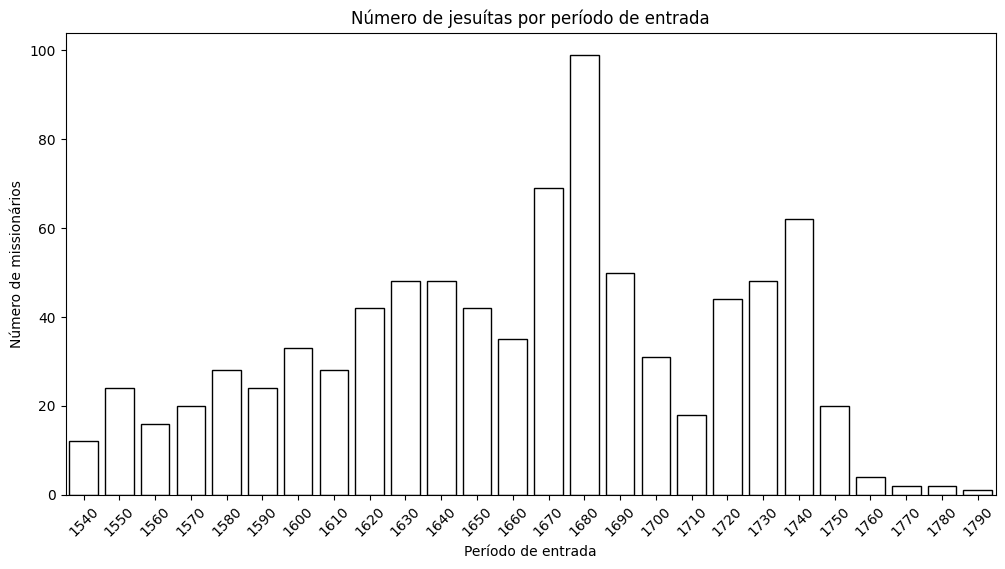

In [30]:
# make a chart of the number of jesuitas-entrada per period ignoring period < 1540
# Label the vertical axis as "Número de missionários"
# Label the horizontal axis as "Período de entrada"
import matplotlib.pyplot as plt
import seaborn as sns

# filter period >= 1540
df = jesuita_entrada_full[jesuita_entrada_full.periodo_entrada >= 1540]

# count number of jesuitas-entrada per period
df = df.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')

# create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='periodo_entrada', y='name', color='white', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Número de jesuítas por período de entrada')

# Label the vertical axis
plt.ylabel('Número de missionários')

# Label the horizontal axis
plt.xlabel('Período de entrada')

plt.show()


### Place of entry "unkown" with country and place of birth

In [31]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    the_value='?',
    more_attributes=['nacionalidade','nascimento'],
    db=tlnb.db,
)
# filter by those with groupname = 'n' (avoid "referido", "pai", "mãe")
jesuita_entrada_full = jesuita_entrada_full[jesuita_entrada_full.groupname=='n']

jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['nacionalidade'] = jesuita_entrada_full['nacionalidade'].fillna('?')
jesuita_entrada_full['name'] = jesuita_entrada_full['name'].fillna('?')
jesuita_entrada_full['nascimento'] = jesuita_entrada_full['nascimento'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['nacionalidade_sort'] = jesuita_entrada_full['nacionalidade'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

cols=['name','nacionalidade','nascimento','jesuita-entrada.date','jesuita-entrada','jesuita-entrada.obs']
jesuita_entrada_full[jesuita_entrada_full.groupname=='n'].sort_values(by=['nacionalidade_sort','name_sort','nascimento'])[cols].head(50)



<class 'pandas.core.frame.DataFrame'>
Index: 407 entries, deh-adam-weidenfied to joao-cardoso
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   407 non-null    object
 1   groupname              407 non-null    object
 2   jesuita-entrada.type   407 non-null    object
 3   jesuita-entrada        407 non-null    object
 4   jesuita-entrada.date   407 non-null    object
 5   jesuita-entrada.line   407 non-null    int64 
 6   jesuita-entrada.level  407 non-null    int64 
 7   jesuita-entrada.obs    407 non-null    object
 8   nacionalidade          404 non-null    object
 9   nacionalidade.date     404 non-null    object
 10  nacionalidade.obs      404 non-null    object
 11  nascimento             402 non-null    object
 12  nascimento.date        402 non-null    object
 13  nascimento.obs         402 non-null    object
dtypes: int64(2), object(12)
memory usage: 47.7+ KB


,name,nacionalidade,nascimento,jesuita-entrada.date,jesuita-entrada,jesuita-entrada.obs
id,,,,,,
deh-bartolome-de-roboredo,Bartolomé de Roboredo,?,?,16460000,?,
deh-herman-scolt,Herman Scolt,?,?,17281228,?,
deh-jacques-barthe,Jacques Barthe,?,?,16780000,?,
deh-adam-weidenfied,Adam Weidenfied,Alemanha,Colónia,16630412,?,
deh-anton-gogeisl,Anton Gogeisl,Alemanha,"Siegenburg, Baviera, diocese de Regensburg",17200913,?,
deh-bernhard-diestel,Bernhard Diestel,Alemanha,"Wippach, Carniole",16391022,?,
deh-christian-henricus,Christian Henricus,Alemanha,?,16420000,?,
deh-christof-brack,Christof Brack,Alemanha,"Diocese de Constance, Rottenburg am Neckar",16720716,?,
deh-franz-moser,Franz Moser,Alemanha,"Mauerkirchen, dicese de Passau",17321003,?,


#### Export to Excel

In [32]:
jesuita_entrada_full[cols].to_excel("../inferences/jesuitas-entrada-desc.xlsx", sheet_name='Sheet_name_1')

#### Export to text file (Portugal)

In [33]:
# Get id of interest
country_of_interest = 'Portugal'
ids = jesuita_entrada_full[jesuita_entrada_full.nacionalidade==country_of_interest].index.unique()

tlnb.db.export_as_kleio(ids,f'../inferences/jesuitas-entrada-desc-{country_of_interest}.txt')

/Users/jrc/develop/timelink-py/timelink/kleio/utilities.py:205: UserWarning: Invalid date: 17309220 -> unconverted data remains: 0
  py_date = convert_timelink_date(tl_datet)
/Users/jrc/develop/timelink-py/timelink/kleio/utilities.py:205: UserWarning: Invalid date: 17402250 -> unconverted data remains: 0
  py_date = convert_timelink_date(tl_datet)
/Users/jrc/develop/timelink-py/timelink/kleio/utilities.py:205: UserWarning: Invalid date: 176001118 -> unconverted data remains: 8
  py_date = convert_timelink_date(tl_datet)


##  Missionaries by specific place of entry in the Jesuit order

Obter os missionários por lugar de entrada na ordem


### Example/Exemplo: Coimbra

Showing palce of birth, embarque (departure).

In [34]:
place_of_entry = "Coimbra"

In [46]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

jesuita_entrada_embarque = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname','extra_info'],
    the_type='jesuita-entrada',
    the_value=place_of_entry,
    more_attributes=['dehergne','nascimento','embarque','morte'],
    db=tlnb.db,
)

# jesuita_entrada_embarque.info()

# user only group "n"
jesuita_entrada_embarque = jesuita_entrada_embarque[jesuita_entrada_embarque.groupname=='n']

# add age at 'jesuita-entrada.date'
jesuita_entrada_embarque['age_at_entrada'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['jesuita-entrada.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_entrada'] = jesuita_entrada_embarque['age_at_entrada'].astype('Int64')

# add age at 'embarque.date'
jesuita_entrada_embarque['age_at_embarque'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['embarque.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_embarque'] = jesuita_entrada_embarque['age_at_embarque'].astype('Int64')
# years between jesuita-entrada and embarque
jesuita_entrada_embarque['entrada_to_embarque'] = jesuita_entrada_embarque['age_at_embarque'] - jesuita_entrada_embarque['age_at_entrada']

# add age at 'morte.date'
jesuita_entrada_embarque['age_at_morte'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['morte.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_morte'] = jesuita_entrada_embarque['age_at_morte'].astype('Int64')

# time in missions
jesuita_entrada_embarque['mission_time'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['embarque.date'], x['morte.date']), axis=1)
# convert to int
jesuita_entrada_embarque['mission_time'] = jesuita_entrada_embarque['mission_time'].astype('Int64')


# format dates
jesuita_entrada_embarque['nascimento.date.formated'] = jesuita_entrada_embarque['nascimento.date'].apply(format_timelink_date)
# create column with year (first 4 characters of 'nascimento.date.formated')
jesuita_entrada_embarque['nascimento.date.year'] = jesuita_entrada_embarque['nascimento.date.formated'].str[:4]

jesuita_entrada_embarque['jesuita-entrada.date.formated'] = jesuita_entrada_embarque['jesuita-entrada.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['jesuita-entrada.date.year'] = jesuita_entrada_embarque['jesuita-entrada.date.formated'].str[:4]
jesuita_entrada_embarque['embarque.date.formated'] = jesuita_entrada_embarque['embarque.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['embarque.date.year'] = jesuita_entrada_embarque['embarque.date.formated'].str[:4]

jesuita_entrada_embarque['morte.date.formated'] = jesuita_entrada_embarque['morte.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['morte.date.year'] = jesuita_entrada_embarque['morte.date.formated'].str[:4]

cols=['dehergne','name','nascimento.date.year',
            'jesuita-entrada.date.year','jesuita-entrada','age_at_entrada','entrada_to_embarque',
            'embarque.date.year','age_at_embarque',
            'morte.date.year','age_at_morte','mission_time','morte','extra_info']
# remove lines with duplicate values for column 'dehergne'
jesuita_entrada_embarque = jesuita_entrada_embarque.sort_values(by=['jesuita-entrada.date.formated','embarque.date.formated']).drop_duplicates(subset=['dehergne'])
jesuita_entrada_embarque.info()
jesuita_entrada_embarque.sort_values(by=['name','jesuita-entrada.date.formated','embarque.date.formated'])[cols]


<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, deh-pedro-de-alcacova to deh-inacio-pires
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           59 non-null     object
 1   groupname                      59 non-null     object
 2   extra_info                     59 non-null     object
 3   jesuita-entrada.type           59 non-null     object
 4   jesuita-entrada                59 non-null     object
 5   jesuita-entrada.date           59 non-null     object
 6   jesuita-entrada.line           59 non-null     int64 
 7   jesuita-entrada.level          59 non-null     int64 
 8   jesuita-entrada.obs            59 non-null     object
 9   dehergne                       59 non-null     object
 10  dehergne.date                  59 non-null     object
 11  dehergne.obs                   59 non-null     object
 12  nascimento                     59 non

,dehergne,name,nascimento.date.year,jesuita-entrada.date.year,jesuita-entrada,age_at_entrada,entrada_to_embarque,embarque.date.year,age_at_embarque,morte.date.year,age_at_morte,mission_time,morte,extra_info
id,,,,,,,,,,,,,,
deh-adriano-pestana,631,Adriano Pestana,1617,1635,Coimbra,17,8,1643,25,,<NA>,<NA>,NaN,{}
deh-afonso-aires,10,Afonso Aires,1630,1649,Coimbra,19,7,1657,26,1657,27,0,"[No mar, depois do Cabo da Boa Esperança]",{}
deh-andre-carneiro,142,André Carneiro,1650,1664,Coimbra,13,31,1694,44,1709,58,14,Goa,{}
deh-andre-ferrao,296,André Ferrão,1625,1640,Coimbra,15,16,1657,31,1661,36,4,"Foochow (Fou-tcheou fou, Fukien)",{}
deh-andre-palmeiro,606,André Palmeiro,1569,1584,Coimbra,14,33,1617,47,1635,65,17,Macau,{}
deh-antao-dantas,235,Antão Dantas,1674,1693,Coimbra,18,1,1694,19,1721,46,26,Goa,{}
deh-antonio-gomes,370,António Gomes,1706,1725,Coimbra,18,2,1727,20,1751,44,23,Pequim,{}
deh-antonio-lopes-junior,485,"António Lopes, júnior",1669,1684,Coimbra,15,11,1695,26,1699,29,3,Macau,{}
deh-antonio-da-silva,768,António da Silva,1654,1669,Coimbra,15,25,1694,40,1726,72,31,Nanquim,{}


In [36]:
# print a list of name and jesuita-entrada.date.year
place_of_entry_ids = jesuita_entrada_embarque.index.unique()
print("Number of people in the list:", len(place_of_entry_ids))
# number print rows
i = 0
for id, name,year,embarque in jesuita_entrada_embarque[['name','jesuita-entrada.date.year','embarque.date.year']].sort_values('name').itertuples(index=True):
    # print number of interactions
    i += 1
    print(f"{i:2} {name} {year}-{embarque} {id}")

Number of people in the list: 59
 1 Adriano Pestana 1635-1643 deh-adriano-pestana
 2 Afonso Aires 1649-1657 deh-afonso-aires
 3 André Carneiro 1664-1694 deh-andre-carneiro
 4 André Ferrão 1640-1657 deh-andre-ferrao
 5 André Palmeiro 1584-1617 deh-andre-palmeiro
 6 Antão Dantas 1693-1694 deh-antao-dantas
 7 António Gomes 1725-1727 deh-antonio-gomes
 8 António Lopes, júnior 1684-1695 deh-antonio-lopes-junior
 9 António da Silva 1669-1694 deh-antonio-da-silva
10 António de Andrade 1596-1600 deh-antonio-de-andrade
11 António de Gouveia 1608-1623 deh-antonio-de-gouvea
12 António de Magalhães 1692-1696 deh-antonio-de-magalhaes
13 António de Melo 1699-1715 deh-antonio-de-melo
14 Belchior Miguel Carneiro Leitão 1543-1555 deh-belchior-miguel-carneiro-leitao
15 Belchior Nunes Barreto 1543-1551 deh-belchior-nunes-barreto
16 Cristóvão da Costa 1550-1551 deh-cristovao-da-costa
17 Diogo Correia Valente 1584-1618 deh-diogo-correia-valente
18 Estanislau Machado 1681-1687 deh-estanislau-machado
19 Estê

#### Export to Excel

In [111]:
jesuita_entrada_embarque[cols].to_excel(f"../inferences/jesuita-entrada-{place_of_entry}.xlsx", sheet_name=f'jesuita_entrada_{place_of_entry}', index=True)

### Analyse trends in decades for specific place of entry

In [37]:
# Extract year from jesuita-entrada.date
jesuita_entrada_embarque['ano_entrada'] = jesuita_entrada_embarque['jesuita-entrada.date'].str[:4]
# Convert 'ano_entrada' to integer
jesuita_entrada_embarque['ano_entrada'] = jesuita_entrada_embarque['ano_entrada'].astype(int)
# Count 'ano_entrada' per periods of 10 years starting from 1540
jesuita_entrada_embarque['periodo_entrada'] = (jesuita_entrada_embarque['ano_entrada'] - 1540) // 10 * 10 + 1540
# Show columns jesuita-entrada.date, ano_entrada, periodo
jesuita_entrada_embarque[['jesuita-entrada.date','ano_entrada','periodo_entrada']].sort_values('jesuita-entrada.date').head(10)


,jesuita-entrada.date,ano_entrada,periodo_entrada
id,,,
deh-pedro-de-alcacova,15420000,1542,1540
deh-belchior-nunes-barreto,15430311,1543,1540
deh-belchior-miguel-carneiro-leitao,15430425,1543,1540
deh-francisco-perez,15440125,1544,1540
deh-tiburcio-de-quadros,15440418,1544,1540
deh-goncalo-alvares,15490101,1549,1540
deh-cristovao-da-costa,15500103,1550,1550
deh-joao-rodrigues-de-sainan,15550000,1555,1550
deh-pedro-martins,15560525,1556,1550


In [38]:
# count number of jesuitas-entrada per period
jesuita_entrada_embarque.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')

,periodo_entrada,name
0,1540,6
1,1550,3
2,1560,2
3,1570,2
4,1580,7
5,1590,5
6,1600,3
7,1610,2
8,1620,2
9,1630,3


In [39]:
# fill missing periods with 0
df_period_place_of_entry = jesuita_entrada_embarque.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')
df_period_place_of_entry = df_period_place_of_entry.set_index('periodo_entrada').reindex(range(1540, 1790, 10)).fillna(0).reset_index()
df_period_place_of_entry

,periodo_entrada,name
0,1540,6.0
1,1550,3.0
2,1560,2.0
3,1570,2.0
4,1580,7.0
5,1590,5.0
6,1600,3.0
7,1610,2.0
8,1620,2.0
9,1630,3.0


#### Make a graph

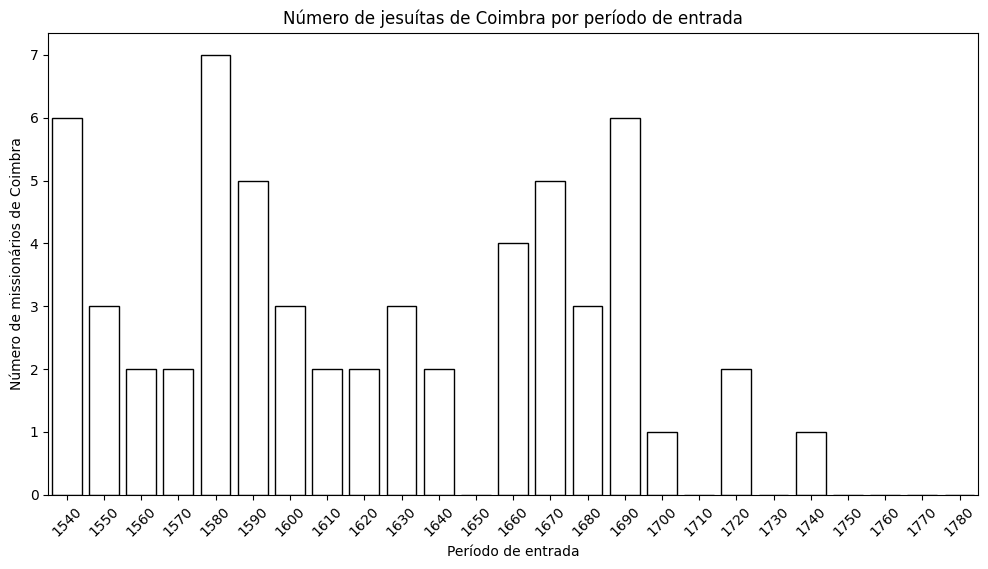

In [40]:
# make a chart of the number of jesuitas-entrada per period ignoring period < 1540
# Label the vertical axis as "Número de missionários de Coimbra"
# Label the horizontal axis as "Período de entrada"
import matplotlib.pyplot as plt
import seaborn as sns

# create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_period_place_of_entry, x='periodo_entrada', y='name', color='white', edgecolor='black')
plt.xticks(rotation=45)
plt.title(f'Número de jesuítas de {place_of_entry} por período de entrada')

# Label the vertical axis
plt.ylabel(f'Número de missionários de {place_of_entry}')

# Label the horizontal axis
plt.xlabel('Período de entrada')

plt.show()

#### Export records to text file as Kleio

In [38]:
tlnb.db.export_as_kleio(jesuita_entrada_embarque.index.unique(), f"../inferences/jesuita-entrada-{place_of_entry}.txt")

#### Export as markdown tables



In [41]:
import os
from pandas import DataFrame
from timelink.pandas import group_attributes as person_attributes

# create if it does not exist directory ../inferences/{place_of_entry}/markdown"
directory = f"../inferences/{place_of_entry}/markdown"
if not os.path.exists(directory):
    os.makedirs(directory)


for id, name,year,embarque in jesuita_entrada_embarque[['name','jesuita-entrada.date.year','embarque.date.year']].sort_values('name').itertuples(index=True):
    with tlnb.db.session() as session:
        p = tlnb.db.get_person(id, session=session)
        session.add(p)
        pk:str = p.to_kleio()
        pk = f"""## {name}
^[In Edit mode, select title (including the ##), right click and "Extract selection"]

---
### {name} @ timelink
```
{pk}
```

---
Select title, right click on selected title, choose extract note
"""
        fname = f"{directory}/{id}.md"
        with open(fname, 'w', encoding='utf-8') as f:
            f.write(pk)



/Users/jrc/develop/timelink-py/timelink/kleio/utilities.py:205: UserWarning: Invalid date: 15007070 -> unconverted data remains: 0
  py_date = convert_timelink_date(tl_datet)
/Users/jrc/develop/timelink-py/timelink/kleio/utilities.py:205: UserWarning: Invalid date: 15951131 -> day is out of range for month
  py_date = convert_timelink_date(tl_datet)


### Export those with place of entry originally unkown by Dehergne

Record in which the place odf entry was added based on extra sources of information.

Check those whoose place of entry was originally undertermined in Dehergne.

Those have the notation '%?' in the transcription and in the database, e.g.:

In the Kleio transcript:

         n$Lourenço Mexia/id=deh-lourenco-mexia
            ...
            ls$jesuita-entrada/Coimbra%?# @wikidata:Q45412 Domingues & O Neil, IV: 2645. MMHM:p.226/15600314#ou 15600325 ou Coimbra, 25-03-1560 MMHM
            ...

In the database:

      ls$jesuita-entrada/Coimbra/15600314/obs=
            """
            extra_info: {
                "date": {"comment": "ou 15600325 ou Coimbra, 25-03-1560 MMHM"}, 
                "value": {"comment": "Domingues & O Neil, IV: 2645. MMHM:p.226", 
                           "original": "?"}}
  """

In [42]:
# List rows if '"original": "?"' is in column 'jesuita_entrada.obs'
cols_2 = ['name','jesuita-entrada','jesuita-entrada.date','jesuita-entrada.obs']
place_of_entry_extra = jesuita_entrada_embarque[jesuita_entrada_embarque['jesuita-entrada.obs'].str.contains('"original": "?"', na=False)][cols_2]
place_of_entry_extra_ids = place_of_entry_extra.index.unique()
print("jesuita-entrada through extra info:",len(place_of_entry_extra_ids))
place_of_entry_extra

jesuita-entrada through extra info: 0


,name,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.obs
id,,,,


#### Save to Excel

In [43]:
place_of_entry_extra.to_excel(f"../inferences/jesuita-entrada-{place_of_entry}-extra_info.xlsx", sheet_name=f'jesuita_entrada_{place_of_entry}_extra', index=True)

Make a list

In [45]:
names_list = sorted(list(place_of_entry_extra.name))

# Join the list into a comma-separated string
comma_separated_names = ', '.join(sorted(names_list))

print(comma_separated_names)
names_list

Adriano Pestana, André Ferrão, André Palmeiro, António de Gouveia, Francisco Furtado, Gabriel de Magalhães, Gaspar do Amaral, Gonçalo da Fonseca, João da Rocha, Lourenço Mexia, Manuel Dias, o Novo, Manuel Gaspar, Mateus de Couros, Matias da Maia, Sebastião Vieira, Sebastião da Maia, Simão da Cunha


['Adriano Pestana',
 'André Ferrão',
 'André Palmeiro',
 'António de Gouveia',
 'Francisco Furtado',
 'Gabriel de Magalhães',
 'Gaspar do Amaral',
 'Gonçalo da Fonseca',
 'João da Rocha',
 'Lourenço Mexia',
 'Manuel Dias, o Novo',
 'Manuel Gaspar',
 'Mateus de Couros',
 'Matias da Maia',
 'Sebastião Vieira',
 'Sebastião da Maia',
 'Simão da Cunha']

#### export to text file

In [46]:

tlnb.db.export_as_kleio(place_of_entry_extra_ids, f"../inferences/jesuita-entrada-{place_of_entry}-extra_info.txt")

#### If place of entry unkown check place of entry in the birthplace 

Check for place of interest in the birth place 
of those with no record of place of entry.

Those born in the same city, district or diocesis as the place 
of entry under analysis are good candidates for further research.


In [47]:
# filter dataframe jesuita_entrada_desc for rows with place_of_entry in in column 'nascimento'
maybe = jesuita_entrada_full[jesuita_entrada_full['nascimento'].str.contains(place_of_entry, na=False)].index.unique()
cols=['name','nacionalidade','nascimento','jesuita-entrada.date','jesuita-entrada','jesuita-entrada.obs']
maybe_place_of_entry = jesuita_entrada_full.loc[maybe]
maybe_place_of_entry.info()
maybe_place_of_entry.sort_values(by=['jesuita-entrada.date'])[cols]

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, deh-antonio-lopes-senior to deh-xavier-duarte
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   29 non-null     object
 1   groupname              29 non-null     object
 2   jesuita-entrada.type   29 non-null     object
 3   jesuita-entrada        29 non-null     object
 4   jesuita-entrada.date   29 non-null     object
 5   jesuita-entrada.line   29 non-null     int64 
 6   jesuita-entrada.level  29 non-null     int64 
 7   jesuita-entrada.obs    29 non-null     object
 8   nacionalidade          29 non-null     object
 9   nacionalidade.date     29 non-null     object
 10  nacionalidade.obs      29 non-null     object
 11  nascimento             29 non-null     object
 12  nascimento.date        29 non-null     object
 13  nascimento.obs         29 non-null     object
 14  nacionalidade_sort     29 non-null     obje

,name,nacionalidade,nascimento,jesuita-entrada.date,jesuita-entrada,jesuita-entrada.obs
id,,,,,,
deh-inacio-lobo,Inácio Lobo,Portugal,Coimbra,16240000,?,
deh-jose-estevao-de-almeida,José Estêvão de Almeida,Portugal,"Esgueira, diocese de Coimbra",16280000,?,
deh-antonio-lopes-senior,"António Lopes, sénior",Portugal,"Taveiro, diocese de Coimbra",16310000,?,
deh-inacio-lobo,Inácio Lobo,Portugal,Coimbra,16350000,?,
deh-luis-pinheiro,Luís Pinheiro,Portugal,"Esgueira, diocese de Coimbra",16370000,?,
deh-luis-pinheiro,Luís Pinheiro,Portugal,"Esgueira, diocese de Coimbra",16450000,?,
deh-joao-couceiro,João Couceiro,Portugal,"Tentúgal, diocese de Coimbra",16490000,?,
deh-jose-soares,José Soares,Portugal,"Santa Comba Dão, diocese de Coimbra",16730300,?,"extra_info: {""date"": {""comment"": ""a 15, 23 ou ..."
deh-antonio-simoes-i,António Simões,Portugal,"Rio de Galinhas, diocese de Coimbra",16780000,?,


In [48]:
print("Number of unique ids:", maybe_place_of_entry.index.nunique())

Number of unique ids: 27


Export maybe place of entry candidates

In [49]:
maybe_place_of_entry[cols].to_excel(f"../inferences/jesuita-entrada-maybe-{place_of_entry}.xlsx", sheet_name=f'jesuita_entrada_maybe_{place_of_entry}', index=True)

Export as text file

In [50]:
tlnb.db.export_as_kleio(maybe_place_of_entry.index.unique(), f"../inferences/jesuita-entrada-maybe-{place_of_entry}.txt")

 ## Roles and tasks of missionaries from specific place of entry

In [51]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

ids = place_of_entry_ids

roles_tasks = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname',],
    the_type=['jesuita-cargo','jesuita-tarefa'],
    column_name='cargos_tarefas',
    more_attributes=[],
    filter_by=ids,
    db=tlnb.db,
)
# remove rows with "cargos_tarefas" NaN
roles_tasks = roles_tasks.dropna(subset=['cargos_tarefas'])
# extract the year from cargos_tarefas.date
roles_tasks['cargos_tarefas.date.year'] = roles_tasks['cargos_tarefas.date'].str[:4]

roles_tasks.info()
cols=['name','cargos_tarefas','cargos_tarefas.type','cargos_tarefas.date.year','groupname',]
# show those without date
# roles_tasks.loc[roles_tasks['cargos_tarefas.date'] == "0", cols].sort_values(['cargos_tarefas.type','cargos_tarefas','cargos_tarefas.date','name']).head(150)
roles_tasks[cols].sort_values(['cargos_tarefas.type','cargos_tarefas','cargos_tarefas.date.year']).head(150)

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, deh-francisco-furtado to deh-jose-montanha-ii
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      174 non-null    object 
 1   groupname                 174 non-null    object 
 2   cargos_tarefas.type       174 non-null    object 
 3   cargos_tarefas            174 non-null    object 
 4   cargos_tarefas.date       174 non-null    object 
 5   cargos_tarefas.line       174 non-null    float64
 6   cargos_tarefas.level      174 non-null    float64
 7   cargos_tarefas.obs        174 non-null    object 
 8   cargos_tarefas.date.year  174 non-null    object 
dtypes: float64(2), object(7)
memory usage: 13.6+ KB


,name,cargos_tarefas,cargos_tarefas.type,cargos_tarefas.date.year,groupname
id,,,,,
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1583,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1584,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1593,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1596,n
deh-lourenco-mexia,Lourenço Mexia,Analista das missões da China e do Japão,jesuita-cargo,1596,n
deh-sebastiao-vieira,Sebastião Vieira,Mestre dos Noviços,jesuita-cargo,1604,n
deh-gaspar-ferreira,Gaspar Ferreira,Mestre dos Noviços,jesuita-cargo,1607,n
deh-lourenco-mexia,Lourenço Mexia,Monitor de Alessandro Valignano,jesuita-cargo,1579,n
deh-jose-montanha-ii,José Montanha,Procurador,jesuita-cargo,1753,n


#### Export to Excel

In [52]:
roles_tasks[cols].to_excel(f"../inferences/jesuita-entrada-{place_of_entry}-cargos_tarefas.xlsx", sheet_name='cargos_tarefas', index=True)

#### Get start and end dates for roles

In [48]:
roles_start_end = roles_tasks[roles_tasks['cargos_tarefas.type']=='jesuita-cargo'].groupby(['name','cargos_tarefas']).agg(
    start_date=('cargos_tarefas.date.year', 'min'),
    end_date=('cargos_tarefas.date.year', 'max')
).reset_index().sort_values(['name','cargos_tarefas','start_date',])
roles_start_end

,name,cargos_tarefas,start_date,end_date
0,André Palmeiro,Visitador das províncias de Goa e do Malabar,1621,1626
1,André Palmeiro,Visitador das províncias do Malabar,1618,1621
2,André Palmeiro,Visitador do Japão e da China,1626,1635
3,António Gomes,Vice-provincial da China,1748,1751
4,António da Silva,Reitor de Nanquim,1699,1699
5,António da Silva,Socius do bispo de Nanquim,1700,1700
6,António da Silva,Vice-provincial da China,1711,1714
7,António de Andrade,Provincial de Goa,1631,1634
8,António de Andrade,Superior de Agra,1624,1624
9,António de Andrade,Visitador de Agra,1624,1624


##### Save to Excel

In [54]:
roles_start_end.to_excel(f"../inferences/jesuita-entrada-{place_of_entry}-cargos_tarefas.datas.xlsx", sheet_name='cargos_tarefas', index=True)

#### Filter by role

In [49]:
# filter
regex = "(.*rovincial|.*Visitador|.*Superior|.*Procurador).*(China.*|Japão.*)"
roles_filtered = roles_start_end[roles_start_end.cargos_tarefas.str.contains(regex, na=False)]
roles_filtered.sort_values(['cargos_tarefas', 'start_date'])

/var/folders/x7/qzytnd752559g0w475rfwkx00000gn/T/ipykernel_13334/863054446.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  roles_filtered = roles_start_end[roles_start_end.cargos_tarefas.str.contains(regex, na=False)]


,name,cargos_tarefas,start_date,end_date
46,Manuel Gaspar,Procurador da China e do Japão,1603,1603
48,Manuel Osório,Procurador da Província do Japão em Macau,1705,1705
35,Gonçalo da Fonseca,Procurador da Vice-província da China,1645,1660
70,Simão da Cunha,Procurador da Vice-província da China,1648,1658
57,Miguel do Amaral,Procurador da Vice-província da China,1694,1722
26,Francisco Pinto,Procurador do Japão,1717,1717
23,Francisco Pacheco,Provincial do Japão,1621,1625
68,Sebastião da Maia,Provincial do Japão,1646,1649
53,Matias da Maia,Provincial do Japão,1658,1661
58,Miguel do Amaral,Provincial do Japão,1702,1718


### Joint biography of entry in Place of interest

In [50]:
from timelink.pandas import display_group_attributes, group_attributes

ids = place_of_entry_ids

no_show=['jesuita-entrada.level','jesuita-entrada.line','dehergne','estadia@wikidata','jesuita-estatuto',
          'nome','nacionalidade','nascimento@wikidata','nome-chines','titulo','jesuita-entrada@wikidata',
          'jesuita-votos-local@wikidata',
          'wicky','wicky-viagem']

show=['jesuita-entrada','embarque','partida','chegada','estadia','cargo','jesuita-cargo','jesuita-tarefa','morte']
display_group_attributes(ids,
                    entity_type='person',
                    header_elements=['name'],
                    sort_header='jesuita-entrada.date',
                    header_attributes=['jesuita-entrada'],
                    include_attributes=show,
                    exclude_attributes=no_show,
                    sort_attributes=['the_date','the_type','the_value'],
                    db=tlnb.db,
                    category='id',
                    cmap_name='Pastel2'
                    )

,name,jesuita-entrada.type,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.line,jesuita-entrada.level,jesuita-entrada.obs,id
0,Pedro de Alcáçova,jesuita-entrada,Coimbra,15420000,296,4,saiu a primeira vez,deh-pedro-de-alcacova
1,Belchior Nunes Barreto,jesuita-entrada,Coimbra,15430311,380,4,,deh-belchior-nunes-barreto
2,Belchior Miguel Carneiro Leitão,jesuita-entrada,Coimbra,15430425,487,4,,deh-belchior-miguel-carneiro-leitao
3,Francisco Pérez,jesuita-entrada,Coimbra,15440125,867,4,,deh-francisco-perez
4,Tibúrcio de Quadros,jesuita-entrada,Coimbra,15440418,14,4,,deh-tiburcio-de-quadros
5,Gonçalo Álvares,jesuita-entrada,Coimbra,15490101,686,4,,deh-goncalo-alvares
6,Cristóvão da Costa,jesuita-entrada,Coimbra,15500103,2166,4,,deh-cristovao-da-costa
7,João Rodrigues de Sainan,jesuita-entrada,Coimbra,15550000,1175,4,,deh-joao-rodrigues-de-sainan
8,Pedro Martins,jesuita-entrada,Coimbra,15560525,797,4,,deh-pedro-martins
9,Lourenço Mexia,jesuita-entrada,Coimbra,15600314,1514,4,,deh-lourenco-mexia


,name,the_type,the_value,the_date,attr_obs,id
0,Belchior Miguel Carneiro Leitão,cargo,Patriarca da Etiópia,0,,deh-belchior-miguel-carneiro-leitao
1,Pedro Martins,cargo,Pregador do rei D. Sebastião,0,,deh-pedro-martins
2,António da Silva,cargo,Vigário de vara,0,il rejette la patente de vic. apostolique et reprend la charge de vicaire de vara,deh-antonio-da-silva
3,Estanislau Machado,cargo,Vigário de vara,0,"Dehergne diz «Vicaire de vara: au sens technique actuel: vicaire forain. En réalité, il s'agit ici d'un représentant envoyé par un évêque portugais sur le territoire d'un vicaire apostolique., en somme un délégué ayant reçu des pouvoirs étendus.»",deh-estanislau-machado
4,Francisco Pacheco,estadia,"Arima, Japão",0,prisioneiro «in odium fidei» e torturado,deh-francisco-pacheco
5,João da Rocha,estadia,"Changchow, Fukien",0,,deh-joao-da-rocha
6,Gonçalo Álvares,estadia,Cochim,0,feito prisioneiro na região de Cochim,deh-goncalo-alvares
7,António Gomes,estadia,Diu,0,,deh-antonio-gomes
8,Manuel de Sá,estadia,Europa,0,,deh-manuel-de-sa
9,Sebastião Vieira,estadia,Filipinas,0,,deh-sebastiao-vieira


## Places of stay / "estadias"

Places of stay: merges different attributes that have location as their value





Can filter by places of entry using
the ids saved above in `place_of_entry_ids`

In [40]:
place_of_stay=None# set to None to show all places

In [41]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

# ids = place_of_entry_ids

places_of_stay = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname','the_line','the_order'],
    the_type=['jesuita-entrada','partida','chegada','estadia','estadia-x',
                'jesuita-votos-local','jesuita-ordenacao-padre','morte'],
    the_value=place_of_stay,
    column_name='place',
    more_attributes=['jesuita-entrada','nascimento'],
    # filter_by=ids,
    db=tlnb.db,
)

# fillna with "?"
places_of_stay.place = places_of_stay.place.fillna('?')

# remove rows where place == '?'
places_of_stay = places_of_stay[places_of_stay.place != '?']

# this sequence replaces missing dates with the value of the previous date
# followed by ">". This allows to use the information that although the date
# is unkown it has happened after a certain date
# we need the id in a column to group by it (it is currently in the index)
# TODO: maybe an option in entities_with_attribute and compute intervals using
#       post quem and ante quem dates. See https://github.com/time-link/timelink-kleio/issues/1
places_of_stay['id_col'] = places_of_stay.index
# create a copy of the date column to replace the '0' values with NaN
places_of_stay['place.date_inferred'] = places_of_stay['place.date'].replace('0', pd.NA)
# order by id and line to have the missing date values filled with the previous date
places_of_stay = places_of_stay.sort_values(by=['id_col', 'place.line'])
# use ffill to fill the missing values with the previous value
places_of_stay['place.date_inferred'] = places_of_stay.groupby(['id_col'])['place.date_inferred'].fillna(method='ffill')
# create a column to flag the inferred dates
places_of_stay['place.date_is_inferred'] = places_of_stay['place.date_inferred'] != places_of_stay['place.date']
# reset index
places_of_stay.reset_index(inplace=True)
# if data_is_inferred set date_inferred to date_inferrred+">"
places_of_stay.loc[places_of_stay['place.date_is_inferred'], 'place.date_inferred'] = places_of_stay['place.date_inferred'] + '>'
# set missing value to ''
places_of_stay['place.date_inferred'].fillna('', inplace=True)
# restore index
places_of_stay.index = places_of_stay['id_col']

places_of_stay.info()
# show results
show_only=100
cols=['groupname','name','nascimento', 'nascimento.date', 'place.type','jesuita-entrada', 'jesuita-entrada.date', 'place','place.date_inferred','place.date_is_inferred','place.line','place.obs']
places_of_stay[places_of_stay.groupname=='n'][cols].sort_values(by=['name','place','place.date_inferred']).head(show_only)



<class 'pandas.core.frame.DataFrame'>
Index: 6282 entries, aloys-moriz to simao-rodrigues-ref1
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      6282 non-null   object
 1   name                    6282 non-null   object
 2   groupname               6282 non-null   object
 3   the_line                6282 non-null   int64 
 4   the_order               6282 non-null   int64 
 5   place.type              6282 non-null   object
 6   place                   6282 non-null   object
 7   place.date              6282 non-null   object
 8   place.line              6282 non-null   int64 
 9   place.level             6282 non-null   int64 
 10  place.obs               6282 non-null   object
 11  jesuita-entrada         5584 non-null   object
 12  jesuita-entrada.date    5584 non-null   object
 13  jesuita-entrada.obs     5584 non-null   object
 14  nascimento              5627 non-nu

,groupname,name,nascimento,nascimento.date,place.type,jesuita-entrada,jesuita-entrada.date,place,place.date_inferred,place.date_is_inferred,place.line,place.obs
id_col,,,,,,,,,,,,
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,estadia,Paris,16650831,Brest,16870301,False,932,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,jesuita-votos-local,Paris,16650831,Caen,16810202,False,947,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,estadia,Paris,16650831,Cantão,16931200,False,938,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,estadia,Paris,16650831,Cantão,17010000,False,939,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,estadia,Paris,16650831,"Chennai, Índia",16920000,False,936,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,estadia,Paris,16650831,Kwangtung,17010000>,True,940,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,jesuita-entrada,Paris,16650831,Paris,16650831,False,931,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,estadia,Paris,16650831,Pondichéry,16910000,False,935,"extra_info: {""date"": {""comment"": ""expulso do S..."
deh-abraham-le-royer,n,Abraham Le Royer,"Domfront, diocese de Mans",16460209,chegada,Paris,16650831,Sião,16870000,False,934,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


### Save to Excel

In [58]:
places_of_stay[cols].sort_values(by=['place','place.date_inferred']).to_excel(f"../inferences/jesuita_entrada_places_of_stay.xlsx", sheet_name='no_wikidata', index=True)

#### Export to Excel all unlocated places

In [59]:
places_of_stay[ ~(places_of_stay['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred']).to_excel(f"../inferences/jesuita_entrada_places_of_stay_no_wikidata.xlsx", sheet_name='no_wikidata', index=True)

#### Only specific place of entry, unkown places

In [60]:
places_of_stay_specific = places_of_stay.loc[place_of_entry_ids]
places_of_stay_specific[~(places_of_stay_specific['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred'])

,groupname,name,place.type,place,place.date_inferred,place.date_is_inferred,place.line,place.obs
id,,,,,,,,
deh-sebastiao-vieira,n,Sebastião Vieira,jesuita-entrada,Coimbra,15910203,False,1094,"extra_info: {""value"": {""comment"": ""([Sch\u00fc..."
deh-goncalo-da-fonseca,n,Gonçalo da Fonseca,jesuita-entrada,Coimbra,16340000,False,1137,"extra_info: {""value"": {""original"": ""? Segundo ..."
deh-goncalo-alvares,n,Gonçalo Álvares,morte,[A caminho do Japão],15730700,False,698,morre afogado com quatro companheiros no camin...
deh-pedro-martins,n,Pedro Martins,morte,"[No mar, a caminho de Malaca]",15980213,False,825,"extra_info: {""date"": {""comment"": ""=morre de fe..."
deh-afonso-aires,n,Afonso Aires,morte,"[No mar, depois do Cabo da Boa Esperança]",16570000,False,191,
deh-gaspar-do-amaral,n,Gaspar do Amaral,morte,[Perto de Hainan],16460226,False,744,"extra_info: {""value"": {""comment"": ""naufr\u00e1..."
deh-pedro-martins,n,Pedro Martins,estadia,[Perto de Moçambique],15840000>,True,811,naufrágio


In [61]:
places_of_stay_specific[~(places_of_stay_specific['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred']).to_excel(f"../inferences/jesuita_entrada_{place_of_entry}_places_of_stay_no_wikidata.xlsx", sheet_name='no_wikidata', index=True)

### Frequency of places / Frequência dos lugares

In [62]:
places_of_stay.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6221 entries, aloys-moriz to simao-rodrigues-ref1
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      6221 non-null   object
 1   name                    6221 non-null   object
 2   groupname               6221 non-null   object
 3   the_line                6221 non-null   int64 
 4   the_order               6221 non-null   int64 
 5   place.type              6221 non-null   object
 6   place                   6221 non-null   object
 7   place.date              6221 non-null   object
 8   place.line              6221 non-null   int64 
 9   place.level             6221 non-null   int64 
 10  place.obs               6221 non-null   object
 11  id_col                  6221 non-null   object
 12  place.date_inferred     6221 non-null   object
 13  place.date_is_inferred  6221 non-null   bool  
dtypes: bool(1), int64(4), object(9)
mem

In [63]:
col = 'place' # subtotal by this column

# Use pandas groupby and specify unique value count for id
df_totals = places_of_stay.groupby(col).agg({'id':'nunique',
                                                'place.date_inferred':'min',
                                                'place.date':'max'})
df_totals.info()
df_totals.sort_values('id',ascending= False).head(130)

<class 'pandas.core.frame.DataFrame'>
Index: 1103 entries, Abissínia to Índia Oriental
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1103 non-null   int64 
 1   place.date_inferred  1103 non-null   object
 2   place.date           1103 non-null   object
dtypes: int64(1), object(2)
memory usage: 34.5+ KB


,id,place.date_inferred,place.date
place,,,
Macau,450,,1773
Pequim,250,,18131213
Goa,209,,17860123
Cantão,197,15550000,17850000
China,180,,18050114
Lisboa,130,,17810300
Roma,111,,18491212
Coimbra,74,15420000,17530000
Paris,65,15270000,17780000


### Place of stay (specific)


List those whose stayed at a specific place



In [36]:
place=place_of_entry

In [44]:
cols = ['place','name','place.type','place.date_inferred','place.obs']
show_only=100
places_of_stay[places_of_stay.place==place][cols].sort_values(by=['place.date_inferred']).head(show_only)


,place,name,place.type,place.date_inferred,place.obs
id_col,,,,,
deh-pedro-de-alcacova,Coimbra,Pedro de Alcáçova,jesuita-entrada,15420000,"saiu a primeira vez extra_info: {""value"": {""co..."
deh-pedro-de-alcacova,Coimbra,Pedro de Alcáçova,jesuita-entrada,15420000,"saiu a primeira vez extra_info: {""value"": {""co..."
deh-belchior-nunes-barreto,Coimbra,Belchior Nunes Barreto,jesuita-entrada,15430311,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-belchior-miguel-carneiro-leitao,Coimbra,Belchior Miguel Carneiro Leitão,jesuita-entrada,15430425,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-francisco-perez,Coimbra,Francisco Pérez,jesuita-entrada,15440125,"extra_info: {""date"": {""comment"": ""j\u00e1 \u00..."
deh-tiburcio-de-quadros,Coimbra,Tibúrcio de Quadros,jesuita-entrada,15440418,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-goncalo-alvares,Coimbra,Gonçalo Álvares,jesuita-entrada,15490101,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-cristovao-da-costa,Coimbra,Cristóvão da Costa,jesuita-entrada,15500103,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-joao-rodrigues-de-sainan,Coimbra,João Rodrigues de Sainan,jesuita-entrada,15550000,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


#### Export to markdown

In [48]:
places_of_stay.itertuples(index=True)

In [50]:
import os
from pandas import DataFrame
from timelink.pandas import group_attributes as person_attributes

# create if it does not exist directory ../inferences/{place_of_entry}/markdown"
directory = f"../inferences/{place_of_entry}/markdown"
if not os.path.exists(directory):
    os.makedirs(directory)


for id, name in places_of_stay[places_of_stay.place==place][['name']].sort_values('name').itertuples(index=True):
    with tlnb.db.session() as session:
        p = tlnb.db.get_person(id, session=session)
        session.add(p)
        pk:str = p.to_kleio()
        pk = f"""## {name}
^[In Edit mode, select title (including the ##), right click and "Extract selection"]

---
### {name} @ timelink
```
{pk}
```

---
Select title, right click on selected title, choose extract note
"""
        fname = f"{directory}/{id}.md"
        with open(fname, 'w', encoding='utf-8') as f:
            f.write(pk)



### Geocoding places

Extract wiki data codes

In [66]:
# column "place.obs" has text that in includes strings such as "@wikidata:Q14773"
# define a function that extracts the wikidata id, e.g. Q14773 from column 'place-obs'
# in order to create a new columns, names "wikidata" with the wikidate id
import pandas as pd

def extract_wikidata_id(df):
    df['wikidata'] = df['place.obs'].str.extract(r'@wikidata:(Q\d+)', expand=False)
    return df

places_of_stay = extract_wikidata_id(places_of_stay)
places_of_stay.info()
cols = ['groupname','name','place.type','place','wikidata','place.date_inferred']
places_of_stay[places_of_stay != '?'][cols].sort_values(by=['place']).head(show_only)

<class 'pandas.core.frame.DataFrame'>
Index: 6221 entries, aloys-moriz to simao-rodrigues-ref1
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      6221 non-null   object
 1   name                    6221 non-null   object
 2   groupname               6221 non-null   object
 3   the_line                6221 non-null   int64 
 4   the_order               6221 non-null   int64 
 5   place.type              6221 non-null   object
 6   place                   6221 non-null   object
 7   place.date              6221 non-null   object
 8   place.line              6221 non-null   int64 
 9   place.level             6221 non-null   int64 
 10  place.obs               6221 non-null   object
 11  id_col                  6221 non-null   object
 12  place.date_inferred     6221 non-null   object
 13  place.date_is_inferred  6221 non-null   bool  
 14  wikidata                5369 non-nu

,groupname,name,place.type,place,wikidata,place.date_inferred
id_col,,,,,,
deh-charles-francois-xavier-de-brevedent,n,Charles-François Xavier de Brévedent,partida,Abissínia,Q207521,16980610
deh-antoine-rene-de-brasle,n,Antoine-René de Brasle,estadia,"Acapulco, México",Q81398,17021226>
deh-antonio-sedeno,n,Antonio Sedeño,estadia,"Acapulco, México",Q81398,15810329
deh-antonio-de-magalhaes,n,António de Magalhães,estadia,Afeganistão,Q889,17000000
deh-philippe-avril,n,Philippe Avril,estadia,Agen,Q6625,16910000
deh-pierre-albier,n,Pierre Albier,jesuita-votos-local,Agen,Q6625,16540712
deh-heinrich-roth-ref1,referido,Johann Grueber,estadia,Agra,Q42941,
deh-bento-de-gois,n,Bento de Góis,estadia,Agra,Q42941,16021029
deh-alano-dos-anjos,n,Alano dos Anjos,estadia,Agra,Q42941,16360000


#### Missing wikidata

In [67]:
missing_wikidata = places_of_stay[places_of_stay.place != '?']
missing_wikidata = missing_wikidata[missing_wikidata.wikidata.isna()]
missing_wikidata.info()
show_only=30
missing_wikidata[cols].sort_values(by=['place']).head(show_only)

<class 'pandas.core.frame.DataFrame'>
Index: 852 entries, aloys-moriz to joao-cardoso
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      852 non-null    object
 1   name                    852 non-null    object
 2   groupname               852 non-null    object
 3   the_line                852 non-null    int64 
 4   the_order               852 non-null    int64 
 5   place.type              852 non-null    object
 6   place                   852 non-null    object
 7   place.date              852 non-null    object
 8   place.line              852 non-null    int64 
 9   place.level             852 non-null    int64 
 10  place.obs               852 non-null    object
 11  id_col                  852 non-null    object
 12  place.date_inferred     852 non-null    object
 13  place.date_is_inferred  852 non-null    bool  
 14  wikidata                0 non-null      obje

,groupname,name,place.type,place,wikidata,place.date_inferred
id_col,,,,,,
deh-jean-baptiste-regis-mae,mae,Louise de Ferrier,estadia,Aix,NaN,16611127
deh-jean-baptiste-regis-pai,pai,Joseph de Regis,estadia,Aix,NaN,16611127
deh-francois-xavier-dentrecolles,n,François-Xavier Dentrecolles,chegada,"Amoy, Fukien",NaN,16990724
deh-francois-xavier-dentrecolles-ref1,referido,Jean-François Foucquet,chegada,"Amoy, Fukien",NaN,16990724
deh-francois-xavier-dentrecolles-ref2,referido,Jean-François Pélisson,chegada,"Amoy, Fukien",NaN,16990724
deh-francois-xavier-dentrecolles-ref3,referido,Pierre Frapperie,chegada,"Amoy, Fukien",NaN,16990724
deh-nicolas-zarate-ref1,referido,Nicéron,estadia,"Amoy, Fukien",NaN,16930000
deh-louis-daniel-le-comte,n,Louis-Daniel Le Comte,estadia,"Amoy, Fukien",NaN,16910000
deh-nicolas-zarate,n,Nicolás Zárate,estadia,"Amoy, Fukien",NaN,16980000


In [68]:

# Use pandas groupby and specify unique value count for id
df_missing_totals = missing_wikidata.groupby(col).agg({'id':'nunique',
                                                'place.date_inferred':'min',
                                                'place.date':'max'})
df_missing_totals.info()
df_missing_totals.sort_values('id',ascending= False).head(130)

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, Aix to Évora
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   456 non-null    int64 
 1   place.date_inferred  456 non-null    object
 2   place.date           456 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.2+ KB


,id,place.date_inferred,place.date
place,,,
"[No mar, a caminho da China]",30,000000,17500624
Tartária,21,,17890000
"Amoy, Fukien",18,16780600,17000829
Hou-kouang,12,,17690108
"Kiangchow, Shansi",10,16280828,16950000
Kiangsi,9,,17980000
Soochow,9,16600000,17590000
Kiang-si,8,16210000,17480128
Kiangchow,7,,17310800


### Wikidata coordinates

In [ ]:
%pip install pywikibot

In [69]:
import pywikibot

wikidata_id = 'Q10783653'
site = pywikibot.Site("wikidata", "wikidata")
repo = site.data_repository()
item = pywikibot.ItemPage(repo, wikidata_id)
item_dict = item.get()
chinese_label = item_dict['labels']['zh']
english_label = item_dict['labels']['en']
# fetch also the Portuguese label if it exists
portuguese_label = item_dict['labels'].get('pt', None)
# fetch the english description if it exists
english_description = item_dict['descriptions'].get('en', None)
print(chinese_label,english_label, f"({english_description})", portuguese_label)
coord = item_dict['claims']['P625'][0].getTarget()
print(coord.lat, coord.lon)

计策市镇 Kẻ Sặt (thị trấn thuộc huyện Bình Giang) None
20.9167 106.15


## Priesthood / Ordens sacras

Those that received the sacrament of priesthood in a given pala

In [70]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_ordenacao_padre = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-ordenacao-padre',
    the_value='Coimbra',
    more_attributes=['dehergne','jesuita-entrada','jesuita-votos-local','nascimento', ],
    db=tlnb.db,
)
jesuita_ordenacao_padre.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_ordenacao_padre['jesuita-votos-local'] = jesuita_ordenacao_padre['jesuita-votos-local'].fillna('?')
jesuita_ordenacao_padre['jesuita-votos-local'] = jesuita_ordenacao_padre['jesuita-votos-local'].fillna('?')

# now we add two columns with sort keys
jesuita_ordenacao_padre['jesuita-votos-loc-sort'] = jesuita_ordenacao_padre['jesuita-votos-local'].apply(coll.sort_key)
jesuita_ordenacao_padre['name_sort'] = jesuita_ordenacao_padre['name'].apply(coll.sort_key)
jesuita_ordenacao_padre

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, deh-pedro-ramon to deh-manuel-de-siqueira-tcheng
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           3 non-null      object
 1   groupname                      3 non-null      object
 2   jesuita-ordenacao-padre.type   3 non-null      object
 3   jesuita-ordenacao-padre        3 non-null      object
 4   jesuita-ordenacao-padre.date   3 non-null      object
 5   jesuita-ordenacao-padre.line   3 non-null      int64 
 6   jesuita-ordenacao-padre.level  3 non-null      int64 
 7   jesuita-ordenacao-padre.obs    3 non-null      object
 8   dehergne                       3 non-null      object
 9   dehergne.date                  3 non-null      object
 10  dehergne.obs                   3 non-null      object
 11  jesuita-entrada                3 non-null      object
 12  jesuita-entrada.date           

,name,groupname,jesuita-ordenacao-padre.type,jesuita-ordenacao-padre,jesuita-ordenacao-padre.date,jesuita-ordenacao-padre.line,jesuita-ordenacao-padre.level,jesuita-ordenacao-padre.obs,dehergne,dehergne.date,...,jesuita-entrada.date,jesuita-entrada.obs,jesuita-votos-local,jesuita-votos-local.date,jesuita-votos-local.obs,nascimento,nascimento.date,nascimento.obs,jesuita-votos-loc-sort,name_sort
id,,,,,,,,,,,,,,,,,,,,,
deh-pedro-ramon,Pedro Ramón,n,jesuita-ordenacao-padre,Coimbra,15730000,49,4,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",670,0,...,15710000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Amakusa,15910801,"extra_info: {""date"": {""comment"": ""e 15910803""}...",Saragoça,15500000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...","(7239, 7594, 7239, 7525, 7861, 7793, 7239, 0, ...","(7692, 7338, 7311, 7731, 7645, 521, 7731, 7239..."
deh-duarte-de-sande,Duarte de Sande,n,jesuita-ordenacao-padre,Coimbra,15770000,305,4,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",741,0,...,15620600,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,15840115,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Guimarães,15471025,"extra_info: {""date"": {""comment"": ""antes de""}, ...","(7412, 7645, 7239, 0, 32, 32, 32, 0, 8, 2, 2, 0)","(7311, 7861, 7239, 7731, 7829, 7338, 521, 7311..."
deh-manuel-de-siqueira-tcheng,Manuel de Siqueira Tcheng,n,jesuita-ordenacao-padre,Coimbra,16640000,1549,4,"extra_info: {""date"": {""comment"": ""morre antes ...",790,0,...,16511017,"segundo a entrada de Rhodes (677), este baptiz...",?,NaN,NaN,Macau,0,"25 maio 1653 é a data que aparece, mas não pod...","(614, 0, 32, 0, 2, 0)","(7594, 7239, 7609, 7861, 7338, 7543, 521, 7311..."


## Vows / Votos

In [52]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-votos',
    more_attributes=['jesuita-votos-local','nascimento', 'jesuita-entrada'],
    db=tlnb.db,
)
jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['jesuita-votos-local'] = jesuita_entrada_full['jesuita-votos-local'].fillna('?')
jesuita_entrada_full['jesuita-votos-local'] = jesuita_entrada_full['jesuita-votos-local'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['jesuita-votos-loc-sort'] = jesuita_entrada_full['jesuita-votos-local'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)


<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, aloys-moriz to joao-cardoso
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      627 non-null    object
 1   groupname                 627 non-null    object
 2   jesuita-votos.type        627 non-null    object
 3   jesuita-votos             627 non-null    object
 4   jesuita-votos.date        627 non-null    object
 5   jesuita-votos.line        627 non-null    int64 
 6   jesuita-votos.level       627 non-null    int64 
 7   jesuita-votos.obs         627 non-null    object
 8   jesuita-votos-local       527 non-null    object
 9   jesuita-votos-local.date  527 non-null    object
 10  jesuita-votos-local.obs   527 non-null    object
 11  nascimento                602 non-null    object
 12  nascimento.date           602 non-null    object
 13  nascimento.obs            602 non-null    object
 14  jesuita-entr

In [72]:
# filter dataframe with rows with index in place_of_entry_ids


In [73]:

df = jesuita_entrada_full[jesuita_entrada_full.index.isin(place_of_entry_ids)].copy()
# calculate age at date "jesuita-votos.date" considering "nascimento.date" as date of birth
# and using the function convert_timelink_date to convert the Timelink date to a Python datetime
df['nascimento.date_2'] = df['nascimento.date'].fillna('0').apply(convert_timelink_date)
df['jesuita-votos.date_2'] = df['jesuita-votos.date'].fillna('0').apply(convert_timelink_date)
# calculate diference in years between the two dates
df['age_at_votos'] = df.apply(lambda row: calc_age_at(row['nascimento.date_2'], row['jesuita-votos.date_2']), axis=1)
df['age_at_votos'] = df['age_at_votos'].fillna(0).astype(int)
df[['nascimento.date','jesuita-votos.date','jesuita-votos','age_at_votos']].head(50)


,nascimento.date,jesuita-votos.date,jesuita-votos,age_at_votos
id,,,,
deh-andre-carneiro,16500000,16821208,4V,32
deh-andre-ferrao,16250000,16590116,4V,33
deh-andre-palmeiro,15690000,16030727,4V,34
deh-antao-dantas,16741102,17110815,4V,36
deh-antonio-da-silva,16540113,16870815,4V,33
deh-antonio-de-andrade,15800000,16121014,4V,32
deh-antonio-de-gouvea,15920000,16460714,4V,54
deh-antonio-de-magalhaes,16770000,17110202,4V,33
deh-antonio-de-melo,16810803,17191203,4V,38


## Voyages


In [61]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

voyage_of_interest = 25

voyage = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='wicky-viagem',
    the_value=str(voyage_of_interest),
    more_attributes=['embarque','chegada','partida',],
    db=tlnb.db,
)
voyage

,name,groupname,wicky-viagem.type,wicky-viagem,wicky-viagem.date,wicky-viagem.line,wicky-viagem.level,wicky-viagem.obs,embarque,embarque.date,embarque.obs,chegada,chegada.date,chegada.obs,partida,partida.date,partida.obs
id,,,,,,,,,,,,,,,,,
deh-duarte-de-sande,Duarte de Sande,n,wicky-viagem,25,15780324,290,4,,S. Luís,15780324,,NaN,NaN,NaN,Macau,15850501,
deh-francesco-pasio,Francesco Pasio,n,wicky-viagem,25,15780324,372,4,,S. Gregório,15780324,,Macau,16120400,,Macau,16120322,
deh-giovanni-gerardino,Giovanni Gerardino,n,wicky-viagem,25,15780324,374,4,,Bom Jesus,15780324,,NaN,NaN,NaN,NaN,NaN,NaN
deh-matteo-ricci,Matteo Ricci,n,wicky-viagem,25,15780324,571,4,,S. Luís,15780324,,Goa,15780913,,Pequim,16000519,
deh-matteo-ricci,Matteo Ricci,n,wicky-viagem,25,15780324,571,4,,S. Luís,15780324,,Macau,15820807,,Pequim,16000519,
deh-matteo-ricci,Matteo Ricci,n,wicky-viagem,25,15780324,571,4,,S. Luís,15780324,,Pequim,16010124,,Pequim,16000519,
deh-michele-ruggiere,Michele (Pompilio) Ruggiere,n,wicky-viagem,25,15780324,1956,4,,S. Luís,15780324,,Macau,15790720,,Roma,15881100,


## Other



###  Remover colunas sem valores

---



###  Remove empty columns

In [75]:
jesuita_entrada_embarque.dropna(how='all', axis=1, inplace=True)
jesuita_entrada_embarque.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, deh-pedro-de-alcacova to deh-inacio-pires
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           59 non-null     object
 1   groupname                      59 non-null     object
 2   jesuita-entrada.type           59 non-null     object
 3   jesuita-entrada                59 non-null     object
 4   jesuita-entrada.date           59 non-null     object
 5   jesuita-entrada.line           59 non-null     int64 
 6   jesuita-entrada.level          59 non-null     int64 
 7   jesuita-entrada.obs            59 non-null     object
 8   dehergne                       59 non-null     object
 9   dehergne.date                  59 non-null     object
 10  dehergne.obs                   59 non-null     object
 11  nascimento                     59 non-null     object
 12  nascimento.date                59 non

In [54]:
jesuita_entrada_embarque.head(5)

,name,groupname,extra_info,jesuita-entrada.type,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.line,jesuita-entrada.level,jesuita-entrada.obs,dehergne,...,age_at_morte,mission_time,nascimento.date.formated,nascimento.date.year,jesuita-entrada.date.formated,jesuita-entrada.date.year,embarque.date.formated,embarque.date.year,morte.date.formated,morte.date.year
id,,,,,,,,,,,,,,,,,,,,,
deh-pedro-de-alcacova,Pedro de Alcáçova,n,{},jesuita-entrada,Coimbra,15420000,296,4,saiu a primeira vez,15,...,56,<NA>,1523,1523,1542,1542,,,1579,1579
deh-belchior-nunes-barreto,Belchior Nunes Barreto,n,{},jesuita-entrada,Coimbra,15430311,380,4,,589,...,52,20,1519,1519,1543-03-11,1543,1551-03-10,1551,1571-08-10,1571
deh-belchior-miguel-carneiro-leitao,Belchior Miguel Carneiro Leitão,n,{},jesuita-entrada,Coimbra,15430425,487,4,,143,...,64,28,1519,1519,1543-04-25,1543,1555-04-01,1555,1583-08-19,1583
deh-francisco-perez,Francisco Pérez,n,{},jesuita-entrada,Coimbra,15440125,867,4,,628,...,68,36,1514,1514,1544-01-25,1544,1546-04-08,1546,1583-02-22,1583
deh-tiburcio-de-quadros,Tibúrcio de Quadros,n,{},jesuita-entrada,Coimbra,15440418,14,4,,666,...,44,17,1528,1528,1544-04-18,1544,1555-04-01,1555,1572-11-21,1572



## Contagens

---

## Counting



###  Contagem de atributos a partir de uma tabela em memória

---

###  Count attributes from an existing dataframe



In [78]:
jesuita_entrada_embarque.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, deh-pedro-de-alcacova to deh-inacio-pires
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           59 non-null     object
 1   groupname                      59 non-null     object
 2   jesuita-entrada.type           59 non-null     object
 3   jesuita-entrada                59 non-null     object
 4   jesuita-entrada.date           59 non-null     object
 5   jesuita-entrada.line           59 non-null     int64 
 6   jesuita-entrada.level          59 non-null     int64 
 7   jesuita-entrada.obs            59 non-null     object
 8   dehergne                       59 non-null     object
 9   dehergne.date                  59 non-null     object
 10  dehergne.obs                   59 non-null     object
 11  nascimento                     59 non-null     object
 12  nascimento.date                59 non

In [55]:
# create a column with the index values which are the id numbers
jesuita_entrada_embarque['id'] = jesuita_entrada_embarque.index.values

col = 'jesuita-entrada' # subotal by this column

# Use pandas groupby and specify unique value count for id
df_totals = jesuita_entrada_embarque.groupby(col).agg({'id':'nunique',
                                                  'jesuita-entrada.date':'min',
                                                  'jesuita-entrada.date':'max'})

df_totals.sort_values('id',ascending= False).head(30)

,id,jesuita-entrada.date
jesuita-entrada,,
Coimbra,59,17420427



### Contagens na base de dados

Quando o atributo tem muitos valores e não é necessário
ter todas as pessoas em memória: contagem feita na base de dados

---

### Counting directly in the database
When there are many values and it is not
necessary to have all the people in memory:
count directly in the database.




In [21]:
from timelink.pandas import attribute_values

df_totals = attribute_values('jesuita-entrada',db=tlnb.db)


In [56]:
df_totals.head(10)


,id,jesuita-entrada.date
jesuita-entrada,,
Coimbra,59,17420427


#### Filtrar por datas

---

#### Filter by dates



In [29]:
df_totals = attribute_values('grau',dates_between=('1535','1600'),db=tlnb.db)

In [30]:
df_totals.head(10)

,count,date_min,date_max
value,,,
Bacharel,9,1554-07-19,1593-06-09
Formatura,6,1574-07-24,1593-05-12
Bacharel em Artes,3,1574-03-14,1588-03-12
Licenciado,3,1574-06-03,1597-05-06
Doutor,2,1560-12-22,1589-10-27
Licenciado em Artes,2,1574-05-15,1589-01-13


## Visualizar registos / View records





### Visualizar uma pessoa / View a person


#### Atributos de uma pessoa numa tabela, uma linha por attributo

---

#### Person attributes in a dataframe, one line per attribute

In [63]:
import pandas as pd
from timelink.pandas import group_attributes as person_attributes

pd.set_option('display.max_rows',1000)

id = 'deh-matteo-ricci'
pdf = person_attributes([id],db=tlnb.db)  # note id in a list
pdf[['the_date','the_type','the_value','attr_obs']].sort_values(['the_date','the_type'])

,the_date,the_type,the_value,attr_obs
id,,,,
deh-matteo-ricci,0,dehergne,684,"Ricci, Matteo (ital.) P. 684 Li Ma-teou, Si-T'..."
deh-matteo-ricci,0,dehergne,684,"P. 25 juill. 1580, à Cochin, où il célèbre sa ..."
deh-matteo-ricci,0,dehergne,684,"D'Elu III, 239-243. Biographie: en chinois: BN..."
deh-matteo-ricci,0,dehergne,684,"Tacchi-Venturi, Opère storiche del P. M. R., M..."
deh-matteo-ricci,0,dehergne,684,id.. L'apport scientifique du P. M. R à la Chi...
deh-matteo-ricci,0,dehergne,684,"Bettray, Johannes, S.V.D., Die akkomodationmet..."
deh-matteo-ricci,0,dehergne,684,"Sur l'art chinois: Sepp Schûller, P. M. Ricci ..."
deh-matteo-ricci,0,dehergne,684,"— Délia Entrata delta Comp. nella Cina, avec a..."
deh-matteo-ricci,0,dehergne,684,"pécimen d'écriture, nom chinois et romanisatio..."


In [64]:
p = tlnb.db.get_person(id)
print(p.to_kleio())

n$Matteo Ricci/m/id=deh-matteo-ricci
  <rel$parentesco/pai/Giovanni Battista Ricci/deh-matteo-ricci-pai/
  <rel$parentesco/mae/Giovanna Angiolelli/deh-matteo-ricci-mae/
  rel$function-in-act/n/lista/dehergne-notices-r//obs=line: 556
  ls$nacionalidade/Itália/
  ls$jesuita-estatuto/Padre/
  ls$nome-chines/Li Ma-teou/
  ls$nome-chines/Si-T'ai/
  ls$tarefa/Calendário cristão na China#introduz?/
  ls$dehergne/684/obs=Ricci, Matteo (ital.) P. 684 Li Ma-teou, Si-T'al (Pf.., et non Ki-Jen, RBS 218)., en portugais Richo (DI. XI, 155, n. 19). N. 6 oct. 1552, Macerata, dans la Marche d'Ancône. E. noviciat St André du Quirinal, Rome, 16 août 1571 (Rom. 171A, 16: il signe: Matteo Riccio). Emb. sur le S. Luis, 24 mars 1578 (W 200)., arr. Goa, 13 sept., et Macao, 7 août 1582., août 1583, Canton., 10 sept. 1583, Shiuhing (Tchao-k'ing fou), où il fonde une résidence., oct. 1589, résidence à Shiuchow (Chao-tcheou)., du 21 mai 1595 au 15 juin, Nankin., 28 juin 1596 au 25 juin 1598, Nan-tch'ang fou., 5 j

#### Atributos de uma pessoa numa tabela, attributos em colunas

---

#### Person attributes in a dataframe, attributes in columns

In [73]:
# Get list of people with with a certain value in a specific attribute

id = 'deh-andre-palmeiro'  # João Pedro Ribeiro
# id = '234295'  # Alexandre Metelo de Sousa
df = entities_with_attribute(
                    entity_type='person',
                    the_type='jesuita-entrada',  # we need a base attribute
                    show_elements=['name'],
                    more_attributes=['jesuita-votos','jesuita-votos-local'],
                    db=tlnb.db,
                    filter_by=[id],
                    sql_echo=False)
view_cols = ['name','jesuita-entrada','jesuita-entrada.date','jesuita-votos','jesuita-votos-local']
df.info()
df[view_cols].sort_values('jesuita-entrada.date')

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, deh-andre-palmeiro to deh-andre-palmeiro
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      1 non-null      object
 1   jesuita-entrada.type      1 non-null      object
 2   jesuita-entrada           1 non-null      object
 3   jesuita-entrada.date      1 non-null      object
 4   jesuita-entrada.line      1 non-null      int64 
 5   jesuita-entrada.level     1 non-null      int64 
 6   jesuita-entrada.obs       1 non-null      object
 7   jesuita-votos             1 non-null      object
 8   jesuita-votos.date        1 non-null      object
 9   jesuita-votos.obs         1 non-null      object
 10  jesuita-votos-local       1 non-null      object
 11  jesuita-votos-local.date  1 non-null      object
 12  jesuita-votos-local.obs   1 non-null      object
dtypes: int64(2), object(11)
memory usage: 220.0+ bytes


,name,jesuita-entrada,jesuita-entrada.date,jesuita-votos,jesuita-votos-local
id,,,,,
deh-andre-palmeiro,André Palmeiro,Coimbra,15840114,4V,Coimbra


#### Examinar potenciais duplicados

---

#### Examine potentital duplicates

In [15]:
from timelink.pandas import display_group_attributes
pd.set_option('display.max_rows',250)

no_show=['código-de-referência','data-do-registo','url','faculdade.ano','naturalidade.ano',
         'matricula-faculdade.ano','nome-apelido','nome-primeiro','nome-geografico.ano',
         'grau.ano','matricula-outra.ano','nome-geografico','instituta.ano']

dup_ids = ['234295','234710',]  # Alexandre Metelo de

display_group_attributes(dup_ids,
                             header_cols=['uc-entrada','naturalidade','faculdade','nome-pai'],
                             exclude_attributes=no_show,
                             sort_attributes=['date','type','value'],
                             ls
                             )

,id,uc-entrada,naturalidade,faculdade,nome-pai
0,234295,1704-11-07,Marialva,Cânones,nan
1,234710,1705-10-24,Marialva,Matemática,Manuel Cardoso Metelo


,date,id,type,value,attr_obs
0,1704-11-07,234295,faculdade,Cânones,Cânones
1,1704-11-07,234295,instituta,1704-11-07,07.11.1704 1704-11-07
2,1704-11-07,234295,naturalidade,Marialva,None
3,1704-11-07,234295,nome,Alexandre Metelo de Sousa,None
4,1704-11-07,234295,uc-entrada,1704-11-07,None
5,1704-11-07,234295,uc-entrada.ano,1704,None
6,1705-10-24,234710,faculdade,Matemática,Matemática
7,1705-10-24,234295,matricula-faculdade,Cânones,24.10.1705
8,1705-10-24,234710,matricula-faculdade,Matemática,24.10.1705
9,1705-10-24,234710,naturalidade,Marialva,None
